# One-Dimensional Climate Models: Brown Dwarfs w/ Disequilibrium Chemistry at Solar M/H and C/O

In this tutorial you will learn how to run 1d climate models with the effects of disequilibrium chemistry as was done for the Elf-OWL Grid [Mukherjee et al. 2024](https://ui.adsabs.harvard.edu/abs/2024arXiv240200756M/abstract) (note this should also be cited if using this code/tutorial). 

What you should already be familiar with: 

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/tutorials.html#basics-of-thermal-emission)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)
- [how to run a basic 1d brown dwarf tutorial](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html)


What should have already downloaded: 

1. [Download](https://zenodo.org/record/5590989#.Yzy2YOzMI8a) 1460 PT, 196 wno Correlated-K Tables from Roxana Lupu to be used by the climate code for opacity 
2. [Download](https://zenodo.org/record/5063476/files/structures_m%2B0.0.tar.gz?download=1) the sonora bobcat cloud free `structures_` file so that you can have a simple starting guess 

**NEW:**

3. [Download the .npy](https://doi.org/10.5281/zenodo.10895826) and place them in picaso_refdata folder/climate_INPUTS/661/

> **_NOTE:_**  Tip for getting data from zenodo: pip install zenodo_get then it you can simply retrieve a zenodo posting via the command zenodo_get 10.5281/zenodo.10895826 


### First, check that you have downloaded and placed the correlated-k files in the correct folder

In [1]:
import os;import glob
#
glob.glob(
    os.path.join(os.environ['picaso_refdata'],'climate_INPUTS','661','*npy')
)
#should see a list of files e.g., "/data/reference_data/picaso/reference/climate_INPUTS/661/AlH_1460.npy"

['/data/reference_data/picaso/reference/climate_INPUTS/661/H2S_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/MgH_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/O2_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/FeH_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/TiO_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/SO2_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/AlH_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/C2H2_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/C2H4_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/C2H6_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/CaH_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/CH4_1460.npy',
 '/data/reference_data/picaso/reference/climate_INPUTS/661/CO_1460.npy',
 '/data/reference_data/picaso/referen

In [2]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from astropy import constants as const
from astropy import units as u
import sys
import pandas as pd


## Setting up Initial Run (highlighting main differences for disequilibrium)

In [3]:
mh = '+000' #log metallicity
CtoO = '100'# CtoO ratio relative to solar

ck_db = f'/data/kcoeff_2020_v3/sonora_2020_feh{mh}_co_{CtoO}.data.196'
sonora_profile_db = '/data/sonora_bobcat/structure/structures_m+0.0' #recommended download #2 above

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities


In [4]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation


tint= 700 
grav = 316 # Gravity of your Planet in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(tint) # input effective temperature

nlevel = 91 


We recommend starting with Sonora-Bobcat models as an initial guess. 

In [5]:
pressure,temp_guess = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{tint}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)


nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr_upper = 79 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,89,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is
print(mh,CtoO,tint)


+000 100 700


### Setting K$_{zz}$

We will add one more concept which is the addition of  K$_{zz}$ [cm$^2$/s]. K$_{zz}$ is the eddy diffusion constant, which sets the strength of vertical mixing. In `PICASO` we have two options for  K$_{zz}$: 
 
 1. Constant value: sets a constant at every atmospheric layer
 2. Self consistent (see Eqn. 27 and 28 in [Mukherjee et al 2022](https://arxiv.org/pdf/2208.07836.pdf))


**New code parameters**: 

0. `diseq_chem=True` : Turns on disequilibrium chemistry
1. `self_consistent_kzz` : (True/False) This solves self consistently for 
2. `save_all_kzz` : (True/False) Similar to `save_all_profiles` this saves your intermediate k_zz values if you are trying to solve for a `self_consistent_kzz=True`.
3. `kz` : constant value if `self_consistent_kzz=False`
4. `gases_fly` : **Important**: determines what gases to include in your climate calculation. if you remove one, it will remove the opacity contirubtion from that gas in your climate calculation
5. `chemeq_first` : Converges a chemical equilibrium model first (helpful for convergence)

**Which of those 6 do I need change change**

Likely you will only be changing `kz` and/or, for example, playing around with a `self_consistent_kzz` vs a `constant profile`. Unless you are certain, we recommend the following set of `gases_fly` to remain unchanged. 


In [6]:
#following elf-owl lets use a constant value for all pressures
kzval = pressure*0+1e2

In [7]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                                           nstr = nstr, nofczns = nofczns , rfacv = rfacv, mh =mh, CtoO = CtoO)


gases_fly = ['CO','CH4','H2O','NH3','CO2','N2','HCN','H2','PH3','C2H2','Na','K','TiO','VO','FeH']

out = cl_run.climate(opacity_ck, save_all_profiles = True, as_dict=True,with_spec=True,
        save_all_kzz = False, diseq_chem = True, self_consistent_kzz =False, kz = kzval,
        on_fly=True,gases_fly=gases_fly, chemeq_first=False)


1 conv Zone, so making small adjustment
New NSTR status is  [ 0 79 89  0  0  0]


From now I will mix ['CO', 'CH4', 'H2O', 'NH3', 'CO2', 'N2', 'HCN', 'H2', 'PH3', 'C2H2', 'Na', 'K', 'TiO', 'VO', 'FeH'] only on--the--fly


Quench Levels are CO, CO2, NH3, HCN, PH3  [66 59 69 65]
PH3 quenched at level 64
DOING DISEQ CALCULATIONS NOW
PH3 quenched at level 64


Iteration number  0 , min , max temp  229.38895295025205 2711.936948558045 , flux balance  0.04984166969045969
Iteration number  1 , min , max temp  227.1063531245356 2722.9807354884542 , flux balance  0.004721639595522151
Iteration number  2 , min , max temp  227.50700875658904 2722.9024884763908 , flux balance  5.7096206552756754e-05
In t_start: Converged Solution in iterations  2
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  227.50700875658904 0
Iteration number  0 , min , max temp  226.03175038683545 2722.5138903648653 , flux balance  0.0010449768257466505
Iteration number  1 , min , max temp  226.0296424182101 2722.5127764710496 , flux balance  7.988962003230321e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
 convection zone status
0 79 89 0 0 0
1
[ 0 65 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  224.4938173190807 2722.381146463197 , flux balance  0.00018869627242149348
Iteration number  1 , min , max temp  224.44523302054148 2722.380940445806 , flux balance  1.3261712937071898e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  224.44523302054148 0
Iteration number  0 , min , max temp  223.6163971864309 2722.3144370602668 , flux balance  4.9820889291579104e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
Grow Phase : Upper Zone
[ 0 64 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  222.64486536038052 2722.157892101776 , flux balance  4.336622984490514e-05
Iteration number  1 , min , max temp  222.61470124444597 2722.157561522271 , flux balance  3.6146019530948797e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  222.61470124444597 0
Iteration number  0 , min , max temp  223.08854219745263 2722.191530621918 , flux balance  -7.052782080332963e-06
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 63 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  221.54843375439972 2721.9283854689447 , flux balance  9.579942824440514e-05
Iteration number  1 , min , max temp  221.49413546042058 2721.9276291908873 , flux balance  8.528843716971716e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  221.49413546042058 0
Iteration number  0 , min , max temp  222.3816773435417 2722.00723195093 , flux balance  -1.691248602573648e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 62 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  220.5922263554595 2721.6835205532175 , flux balance  0.00015136087897987105
Iteration number  1 , min , max temp  220.52561075995666 2721.6823491517143 , flux balance  1.4291828916724102e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  220.52561075995666 0
Iteration number  0 , min , max temp  221.78534008549963 2721.799542944217 , flux balance  -2.3793696485175693e-05
 We are already at a root, tolf , test =  5e-05 ,  3.6884520775002164e-05
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 61 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  223.3249949101285 2721.2237580552846 , flux balance  0.00022748653293050807
Iteration number  1 , min , max temp  223.3383197421195 2721.2208527673815 , flux balance  2.252630952448013e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  223.3383197421195 0
Iteration number  0 , min , max temp  222.2537661989956 2721.6506966827183 , flux balance  -1.8262818836340393e-05


Iteration number  1 , min , max temp  222.22290460822586 2721.6518212603296 , flux balance  -1.3873789747441914e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 60 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  223.34924492239622 2721.037867927192 , flux balance  0.00024930373654901013
Iteration number  1 , min , max temp  223.36282223299511 2721.034462108423 , flux balance  2.5996562874234426e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  223.36282223299511 0
Iteration number  0 , min , max temp  222.15658548482293 2721.477971365273 , flux balance  -2.0976563427232276e-05


Iteration number  1 , min , max temp  222.12094488852884 2721.479037229674 , flux balance  -1.8647719934834454e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 59 65 65 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  223.34800063350582 2720.8778593444226 , flux balance  0.0002522740069903005
Iteration number  1 , min , max temp  223.36345513534982 2720.874257018312 , flux balance  2.7513482583797174e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Big iteration is  223.36345513534982 0
Iteration number  0 , min , max temp  222.1370579502925 2721.33596798818 , flux balance  -2.5453137056438913e-05
Iteration number  1 , min , max temp  222.1010162320837 2721.336945369393 , flux balance  -2.6873542903664857e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [66 60 69 65]


Profile converged
[ 0 59 66 66 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  223.76137295170352 2720.6240989692283 , flux balance  9.574628985760522e-05
Iteration number  1 , min , max temp  223.77518768500792 2720.620078824715 , flux balance  7.701564591816793e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Big iteration is  223.77518768500792 0
Iteration number  0 , min , max temp  225.27954275380498 2720.854761008368 , flux balance  -4.449727804903615e-05
Iteration number  1 , min , max temp  225.29697699360668 2720.8543742712172 , flux balance  -5.665822404322083e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Profile converged
[ 0 58 66 66 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  223.84676015514313 2720.431055370923 , flux balance  0.00015793929153186986
Iteration number  1 , min , max temp  223.8037642319122 2720.425775109596 , flux balance  1.649958020039473e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Big iteration is  223.8037642319122 0
Iteration number  0 , min , max temp  225.23884478470274 2720.7025387569493 , flux balance  -6.698123109432e-05


Iteration number  1 , min , max temp  225.2581299138347 2720.701270748501 , flux balance  -9.9076674640358e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Profile converged
[ 0 57 66 66 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  224.0604498894272 2720.3424873599597 , flux balance  0.00013159251862948504
Iteration number  1 , min , max temp  224.0290769172286 2720.337465773177 , flux balance  1.2574839481718196e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Big iteration is  224.0290769172286 0
Iteration number  0 , min , max temp  225.5254239648325 2720.5964145146586 , flux balance  -7.350358954116712e-05
Iteration number  1 , min , max temp  225.545191617907 2720.59498492588 , flux balance  -1.1753915682356817e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Profile converged
[ 0 57 67 67 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  226.20712854443877 2720.0766512203218 , flux balance  9.309700685203061e-08
Iteration number  1 , min , max temp  226.22126570617482 2720.0714368512354 , flux balance  -6.753711698357201e-07
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Big iteration is  226.22126570617482 0
Iteration number  0 , min , max temp  226.89361948556 2720.2213052729044 , flux balance  -4.84095563956195e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Profile converged
[ 0 56 67 67 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  226.0952253405692 2719.9594641173094 , flux balance  6.40844102220685e-06
Iteration number  1 , min , max temp  226.08487273127892 2719.950812898095 , flux balance  -1.1073882677711846e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Big iteration is  226.08487273127892 0
Iteration number  0 , min , max temp  226.897878352331 2720.1181937576325 , flux balance  -8.152906492468351e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Profile converged
[ 0 56 68 68 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  228.01875159274593 2719.739486576464 , flux balance  -9.308822122785567e-05
Iteration number  1 , min , max temp  228.0415881729798 2719.7312502527006 , flux balance  -2.643906397257258e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Big iteration is  228.0415881729798 0
Iteration number  0 , min , max temp  228.69195279601925 2719.8292995732913 , flux balance  -3.437635251130181e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Profile converged
[ 0 55 68 68 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  228.312725090583 2719.666446111637 , flux balance  -0.00013520333521576164
Iteration number  1 , min , max temp  228.32308627556515 2719.6514553985808 , flux balance  -4.45029138771542e-06
In t_start: Converged Solution in iterations  1
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Big iteration is  228.32308627556515 0
Iteration number  0 , min , max temp  228.90997035601072 2719.7487696998287 , flux balance  -6.562930811979795e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Profile converged
[ 0 54 68 68 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  228.88529787619495 2719.6730655961774 , flux balance  -0.00014876576959163044
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Big iteration is  228.88529787619495 0
Iteration number  0 , min , max temp  229.3433472195568 2719.7135168211403 , flux balance  -4.982590921827776e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Profile converged
[ 0 54 69 69 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  229.8370314472166 2719.5087629213026 , flux balance  -5.630889139436589e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Big iteration is  229.8370314472166 0
Iteration number  0 , min , max temp  230.04642217078626 2719.5832771333517 , flux balance  -2.106919663005374e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Profile converged
[ 0 53 69 69 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  229.98760195421 2719.520663537039 , flux balance  -6.432541222010846e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Big iteration is  229.98760195421 0
Iteration number  0 , min , max temp  230.10819573409393 2719.57553876106 , flux balance  -2.0206411238823837e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Profile converged
final [ 0 53 69 69 79 89]
PH3 quenched at level 64


Iteration number  0 , min , max temp  230.15873145266693 2719.5384018782433 , flux balance  1.0117039694499035e-05
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Big iteration is  230.15873145266693 0
Iteration number  0 , min , max temp  230.16786437273117 2719.581311361691 , flux balance  -7.611713749657457e-07
In t_start: Converged Solution in iterations  0
PH3 quenched at level 64
Quench Levels are CO, CO2, NH3, HCN  [67 60 69 65]


Profile converged
YAY ! ENDING WITH CONVERGENCE
PH3 quenched at level 64


## Compare Diseq and Chemeq Climate Profile 

For the case we chose with very low kzz, and solar M/H the disequilibrium profile and bobcat profiles are identical! 

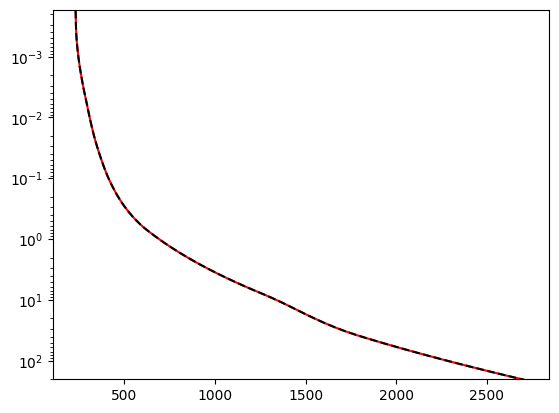

In [8]:
plt.ylim(200,1.7e-4)
plt.semilogy(out['temperature'],out['pressure'],"r", label='Elf-OWL Style, Disequilibrium')
plt.semilogy(temp_guess,pressure,color="k",linestyle="--", label='Bobcat, Chemical Equilibrium')